In [ ]:
# Load libraries
import pandas as pd
from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px



In [ ]:
# Load the dataset
df=pd.read_csv('/content/transactions_casestudy.txt', sep='|')  
#df = df.sample(n = 5000, random_state=0)


# EDA

In [ ]:
df.head()

,tid,date,daypart,channel,items
0,1,2016-03-02,A,1,"21d683,21d683"
1,2,2016-03-02,A,1,"aa254f,524e24,2f4a70,6ca4a6,221380,b8bfe8,2213..."
2,3,2016-03-02,A,2,"fe5db1,aa254f,550e0e,7356a8,7356a8"
3,4,2016-03-02,A,2,4d51b8
4,5,2016-03-02,A,2,6050b0


### Missing values

In [ ]:
# Checking for missing values
missing = df.isnull().sum()
print(missing)

tid        0
date       0
daypart    0
channel    0
items      0
dtype: int64


### dtypes

In [ ]:
df.dtypes

tid         int64
date       object
daypart    object
channel     int64
items      object
dtype: object

### Items count by transaction histogram

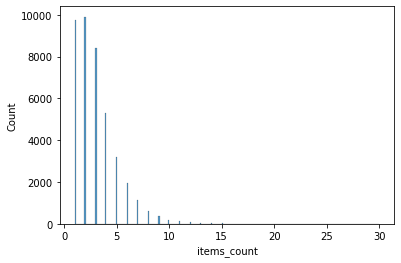

In [ ]:
# replace coma with space in the items feature
df['items'] = df['items'].str.replace(',',' ')

# create feature for counting the number of items
df['items_count']=df['items'].str.count(' ') + 1

# Items count by transaction histogram
sns.histplot(data=df, x="items_count")

### Items histogram

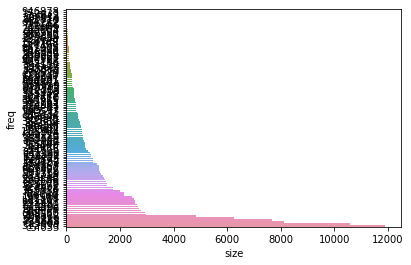

In [ ]:
# BOW for all the items
all_items = []
for trans in df["items"]:
  all_items += trans.split()

# Calculate the frequency of the items
freq = pd.DataFrame({'freq': all_items})
freq.sort_values(by="freq", ascending=False, inplace=True)
freq= freq.groupby('freq', as_index=False).size()
freq= freq.sort_values(by=['size'])
sns.barplot(x="size", y="freq", data=freq)

### Channel histogram

2    36689
3     4111
1      495
Name: channel, dtype: int64

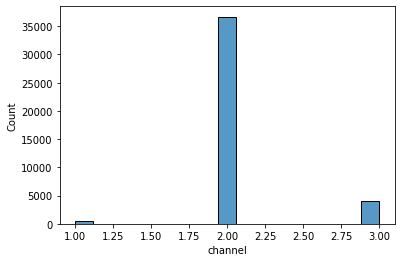

In [ ]:
# Channel histogram
sns.histplot(data=df, x="channel")
df["channel"].value_counts(())

### Day-part histogram

A    11161
B     9813
E     8394
F     4471
C     4188
D     3268
Name: daypart, dtype: int64

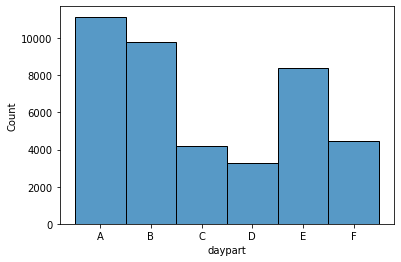

In [ ]:
# daypart histogram
sns.histplot(data=df, x="daypart")
df["daypart"].value_counts(())

## Pre-processing 

In [ ]:
# Extract day & month from time feature
df['month'] = df['date'].apply(lambda x: 0 if x[6]==3 else 1)
df['day'] = df['date'].apply(lambda x: x[8:10])

# Drop unnecessary features
df.drop(['tid','date'], inplace=True, axis=1)

# Add 'None' item to 1 items transaction
df.loc[df['items_count'] == 1, 'items'] += ' None'

### One-Hot Encoding

In [ ]:
# Transform categorical features to dummies
non_dummy_cols = ['items','items_count'] 
dummy_cols = list(set(df.columns) - set(non_dummy_cols))
df = pd.get_dummies(df, columns=dummy_cols)

## Train-Test split

In [ ]:
# Split the data frame with 80-20% ratio
df_train = df.sample(frac = 0.8, random_state=42)
df_test = df.drop(df_train.index)

Transaction: [aa254f 524e24 2f4a70 6ca4a6 221380 b8bfe8 2213 b8bfe8]

In [ ]:
'''Create a new data frame where:
'input item': one of the items in the list
'items_purchased': items to the left of 'item', i.e the items purchased after
'target': on of the items from 'items_purchased' list
'''
df_train_full = pd.DataFrame()

# Run over each row in the df_train
for k in tqdm ( range(len(df_train)) ):
  row = df_train.iloc[k]
  sentence= row["items"].split()
  number_of_items=row["items_count"]

  # In case of one item transaction append be the following
  if (number_of_items==1):
      row["input_item"]=sentence[0]
      row["target"]=sentence[1]
      df_train_full=df_train_full.append(row)
  else:
    # Run over the items for each transaction
    for i in range(0, number_of_items):
      for j in range(i+1, number_of_items):
        row["input_item"]=sentence[i]
        row["target"]=sentence[j]
        df_train_full=df_train_full.append(row)


  0%|          | 0/33036 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)
100%|██████████| 33036/33036 [1:07:09<00:00,  8.20it/s]


In [ ]:
df_train_full.shape

(187883, 45)

## word2vec embedding model training

In [ ]:
# Tokenized the transactions for lists of items
tokenized_sent= df_train['items'].apply(lambda x: x.split())

# Train the word2vec model
word_model = Word2Vec(sentences=tokenized_sent, min_count=1)

In [ ]:
# Define the simple average sentence embedding
def simple_average(sents, word_model):
    sents_emd = []
    for s in sents:
        sent_emd = []
        for w in s.split():
          sent_emd.append(word_model[w])
        sent_emd_ar = np.array(sent_emd)
        sum_ = np.array(sent_emd).sum(axis=0)
        result = sum_/np.sqrt((sum_**2).sum())
        sents_emd.append(result)
        
    return sents_emd

# Define the encoder process
def word_encoder(df_to_ecode, word_model):
  vectors_df = pd.DataFrame( simple_average(df_to_ecode["input_item"], word_model) )

  # Joint the vectors to the data frame
  df_to_ecode.reset_index(drop=True, inplace=True)
  vectors_df.reset_index(drop=True, inplace=True)
  df_to_ecode = pd.concat( [df_to_ecode, vectors_df], axis=1)

  return df_to_ecode

# Encde the train-set
X_train = word_encoder(df_train_full, word_model)
X_train.drop(['input_item','items'], inplace=True, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


In [ ]:
X_train.head(3)

,items_count,month_1,channel_1,channel_2,channel_3,daypart_A,daypart_B,daypart_C,daypart_D,daypart_E,...,90,91,92,93,94,95,96,97,98,99
0,8.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.007449,-0.027078,0.185467,-0.20865,-0.031215,-0.004502,-0.054068,0.011063,0.130451,0.025819
1,8.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.007449,-0.027078,0.185467,-0.20865,-0.031215,-0.004502,-0.054068,0.011063,0.130451,0.025819
2,8.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.007449,-0.027078,0.185467,-0.20865,-0.031215,-0.004502,-0.054068,0.011063,0.130451,0.025819


## Test-set pre-processing

Transaction: [aa254f 524e24 2f4a70 6ca4a6 221380 b8bfe8 2213 b8bfe8]

In [ ]:
# Set the input and target featurs for the test-set
df_test['input_item'] = df['items'].apply(lambda x: x.split()[0])
df_test['items_purchased'] = df['items'].apply(lambda x: x.split()[1:])

# Encode the input test-set
X_test = word_encoder(df_test, word_model)
X_test.drop(['input_item','items'], inplace=True, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


## Train Logistic Regression classifier

In [ ]:
# Extract the target feature for the classifier training
y_train=X_train["target"]
X_train.drop('target', inplace=True, axis=1)

# Extract the target feature hit-rate metric
y_test=X_test["items_purchased"]
X_test.drop('items_purchased', inplace=True, axis=1)

# Fit Logistic Regression model
clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)

# Predict the probability vectors for the test instances
y_pred_prob = clf.predict_proba(X_test)

# Get the items list by index
items_by_ind=clf.classes_

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarn

## Hit-Rate metric


**Example**

Predicted top n: [aa254f 524e24 2f4a70]


True items purchased: [aa254f aa254f aa254f]

Total hit-rate: 3/3=1


Total hit-rate per item: 1/3=0.33

In [ ]:
''''Define the hit rate metric where:
total hits calculated as the correct suggestion multiple by the number of true perceived items
total miss calculated as the incorrect suggestions while a transaction with less than the suggestion items is not included '''

def hit_rate(y_pred_prob, items_purchased, items_by_ind, threshold=0.05):
  total_hits=0
  total_item_hits_=0
  total_miss=0
  list_zip = zip(y_pred_prob, items_purchased)
  for prob_vec, true_items in list_zip:
    ind = np.argpartition(prob_vec, -5)[-5:]
    top_n = items_by_ind[ind[2:5]]
    if (prob_vec[ind[1]] > threshold):
      top_n= np.append(top_n, items_by_ind[ind[1]])
    if (prob_vec[ind[0]] > threshold):
      top_n=np.append(top_n, items_by_ind[ind[0]])
    total_hits += len(list(filter(top_n.__contains__, true_items)))
    total_item_hits_ += len(list(filter(true_items.__contains__, top_n)))
    total_miss += min(3, len(true_items))

    if (total_miss % 1000 == 0):
      print("Top n:", top_n)
      print("True purchased items", true_items)

  return total_hits/total_miss, total_item_hits_/total_miss

hit_results, item_hit_results= hit_rate(y_pred_prob, y_test, items_by_ind)

In [ ]:
print ( "Total hit-rate:",round(hit_results, 3) )
print ( "Total hit-rate per item:",round(item_hit_results, 3) )

Total hit-rate: 0.668
Total hit-rate per item: 0.495


## Predict for 1+ item(s)

In [ ]:
# aa254f,524e24,2f4a70,6ca4a6,221380,b8bfe8,221380,221380,221380,363929,363929

sample_1= df_test.iloc[0:1]
sample_1['input_item'].iloc[0]='aa254f 524e24 2f4a70'
sample_1['items_purchased'].iloc[0]=["6ca4a6", "221380", "b8bfe8", "221380", "221380", "363929", "363929"]

X_test = word_encoder(sample_1, word_model)
X_test.drop(['input_item','items'], inplace=True, axis=1)

# Extract the target feature hit-rate metric
y_test=X_test["items_purchased"]
X_test.drop('items_purchased', inplace=True, axis=1)

# Predict the probability vectors for the test instances
y_pred_prob = clf.predict_proba(X_test)

hit_results, item_hit_results= hit_rate(y_pred_prob, y_test, items_by_ind)

print ( "Total hit-rate:",round(hit_results, 3) )
print ( "Total hit-rate per item:",round(item_hit_results, 3) )